# Toy example

Original notebook by Alexander Held, edited for the MadMiner repository by Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

In this notebook, we use a simple toy example to demonstrate the machine learning and inference algorithms in MadMiner. This allows us to skip many of the more technical steps, and there's no dependency on MadGraph, Pythia, or Delphes.

What this tutorial does not do, is explaining the inference methods. To understand what's happening, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013), which will explain the basic idea in just a few pages. If you really want to get down to the dirty details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) has you covered.

## Preparations

In [1]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import math

%matplotlib inline

from madminer.ml.ensemble import Ensemble
from madminer.ml import ParameterizedRatioEstimator, ScoreEstimator, BayesianScoreEstimator, HeteroskedasticScoreEstimator, RepulsiveEnsembleScoreEstimator

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [3]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. A toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

As in the particle physics case, we assume that we can calculate the joint likelihood ratio `r(x, z | theta0, theta1)` as well as the joint score `t(x, z | theta)`, which depend explicitly on `z` (and where the "detector" part cancels).

Here are some general settings (feel free to play with them): 

In [4]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta` and calculates the joint likelihood ratio between `theta0` and `theta1` as well as the joint score at `theta_score`:

In [5]:
def simulate(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc=theta, scale=z_std, size=npoints)

    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    # Calculate joint likelihood ratio and joint score
    if theta0 is not None and theta1 is not None:
        r_xz = norm(loc=theta0, scale=z_std).pdf(z) / norm(loc=theta1, scale=z_std).pdf(z)
    else:
        r_xz = None

    if theta_score is not None:
        t_xz = 2*(z - theta_score) / z_std**2
    else:
        t_xz = None

    return x, r_xz, t_xz

Usually the likelihood function `p(x|theta)` is intractable, but in this toy example it is just given by the convolution of two Gaussians, which is again a Gaussian. We will use this to validate the results later:

In [6]:
def calculate_likelihood_ratio(x, theta0, theta1=0.0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = norm(loc=theta0, scale=combined_std).pdf(x) / norm(loc=theta1, scale=combined_std).pdf(x)
    return r_x

## repulsive ensemble

In [7]:
class StackedLinear(nn.Module):
    """
    Efficient implementation of linear layers for ensembles of networks
    """
    def __init__(self, in_features, out_features, channels):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.channels = channels
        self.weight = nn.Parameter(torch.empty((channels, out_features, in_features)))
        self.bias = nn.Parameter(torch.empty((channels, out_features)))
        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.channels):
            torch.nn.init.kaiming_uniform_(self.weight[i], a=math.sqrt(5))
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight[i])
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            torch.nn.init.uniform_(self.bias[i], -bound, bound)

    def forward(self, input):
        return torch.baddbmm(self.bias[:,None,:], input, self.weight.transpose(1,2))

def kernel(x, y):
    """
    RBF kernel with median estimator
    """
    channels = len(x)
    dnorm2 = (x.reshape(channels,1,-1) - y.reshape(1,channels,-1)).square().sum(dim=2)
    sigma = torch.quantile(dnorm2.detach(), 0.5) / (2 * math.log(channels + 1))
    return torch.exp(- dnorm2 / (2*sigma))

In [8]:
def train_repulsive_ensemble(x, y):
    channels = 100
    iterations = 1000
    n_samples = len(x)
    prior_width = 1.

    model = nn.Sequential(
        StackedLinear(1, 10, channels),
        nn.ReLU(),
        StackedLinear(10, 10, channels),
        nn.ReLU(),
        StackedLinear(10, 2, channels),
    )
    opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1 / (2*n_samples*prior_width**2))
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, iterations)

    xt = torch.tensor(x[None,:,None], dtype=torch.float32).expand(channels,-1,-1)
    print("dim of x:", x.shape)
    print("dim of xt:", xt.shape, x[None,:,None].shape)
    yt = torch.tensor(y[None,:], dtype=torch.float32).expand(channels,-1)

    for i in range(iterations):
        h = model(xt)
        mu, log_sigma2 = h[:,:,0], h[:,:,1]
        
        # Heteroscedastic regression loss
        reg = 0.5 * ((yt - mu)**2 / log_sigma2.exp() + log_sigma2)
        
        # repulsive ensemble loss
        k = kernel(reg, reg.detach())
        reg_mean, reg_std = reg.mean(dim=1), reg.std(dim=1)
        loss = torch.sum(reg_mean + (k.sum(dim=1) / k.detach().sum(dim=1) - 1) / len(x), dim=0)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        sched.step()
        print(f"iteration {i}: loss={loss}")
        if i % 100 == 0:
            print(f"mean={reg_mean.mean().item():.4f}, std={reg_mean.std().item():.4f}, " +
                f"min={reg_mean.min().item():.4f}, max={reg_mean.max().item():.4f}")

    return model

## 2. Run the simulation and generate training data

In [9]:
# number of parameter points to train
n_param_points = 1000

# numerator, uniform prior
theta0 = np.zeros(shape=n_param_points)

# Sample from theta0
x_from_theta0, r_xz_from_theta0, t_xz_from_theta0 = simulate(theta0, theta0, theta0, theta0)

# Combine results and reshape
# x_train = np.hstack((x_from_theta0, x_from_theta1)).reshape(-1, 1)
# r_xz_train = np.hstack((r_xz_from_theta0, r_xz_from_theta1)).reshape(-1, 1)
# t_xz_train = np.hstack((t_xz_from_theta0, t_xz_from_theta1)).reshape(-1, 1)
# y_train = np.hstack((np.zeros_like(x_from_theta0), np.ones_like(np.ones_like(x_from_theta1)))).reshape(-1, 1)
# theta0_train = np.hstack((theta0, theta0)).reshape(-1, 1)
x_train = x_from_theta0
t_xz_train = t_xz_from_theta0

# Save to file
np.save("data/x_train.npy", x_train)
np.save("data/t_xz_train.npy", t_xz_train)

In [10]:
def calculate_true_score(x, theta):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = 2*(x - theta)/combined_std**2
    return r_x

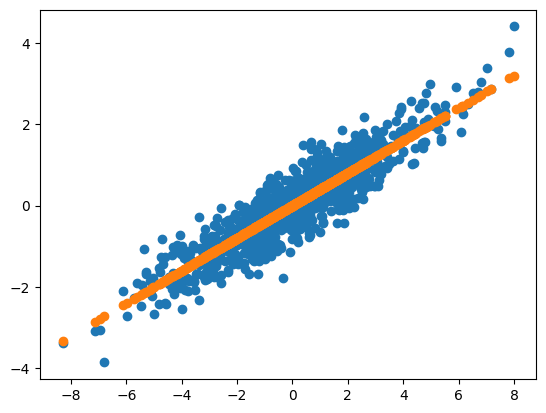

In [11]:
fig, ax = plt.subplots()

plt.scatter(x_train, t_xz_train)
plt.scatter(x_train, calculate_true_score(x_train, 0.0))

plt.show()

## 3. Model training

Let's train two neural networks to estimate the likelihood ratio. For one we use the CARL method introduced in ["Approximating Likelihood Ratios with Calibrated Discriminative Classifiers"](https://arxiv.org/abs/1506.02169), for the other the new ALICES method introduced in ["Likelihood-free inference with an improved cross-entropy estimator"](https://arxiv.org/abs/1808.00973).

In [12]:
repulsive_ensemble = train_repulsive_ensemble(x_train, t_xz_train)

dim of x: (1000,)
dim of xt: torch.Size([100, 1000, 1]) (1, 1000, 1)
iteration 0: loss=63.262203216552734
mean=0.6326, std=0.2157, min=0.3369, max=1.5539
iteration 1: loss=53.03074645996094
iteration 2: loss=45.549869537353516
iteration 3: loss=39.74598693847656
iteration 4: loss=34.98585891723633
iteration 5: loss=30.88193130493164
iteration 6: loss=27.248554229736328
iteration 7: loss=23.897621154785156
iteration 8: loss=20.712631225585938
iteration 9: loss=17.71187973022461
iteration 10: loss=14.933403968811035
iteration 11: loss=12.309125900268555
iteration 12: loss=9.718376159667969
iteration 13: loss=7.156370162963867
iteration 14: loss=4.67378568649292
iteration 15: loss=2.386418104171753
iteration 16: loss=0.3218461275100708
iteration 17: loss=-1.6680136919021606
iteration 18: loss=-3.6746838092803955
iteration 19: loss=-5.61008358001709
iteration 20: loss=-7.490745544433594
iteration 21: loss=-9.323936462402344
iteration 22: loss=-10.947315216064453
iteration 23: loss=-12.3728

In [15]:
# import cProfile

repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator(n_hidden=(10, 10))

# cProfile.run("""
repulsive_ensemble_sally.train(
    method="repulsive_ensemble_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=1000,
)
# """, "trainstats")
repulsive_ensemble_sally.save("models/repulsive_ensemble_sally")

16:38 madminer.ml.score    INFO    Starting training
16:38 madminer.ml.score    INFO      Batch size:             128
16:38 madminer.ml.score    INFO      Optimizer:              amsgrad
16:38 madminer.ml.score    INFO      Epochs:                 1000
16:38 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:38 madminer.ml.score    INFO      Validation split:       0.25
16:38 madminer.ml.score    INFO      Early stopping:         True
16:38 madminer.ml.score    INFO      Scale inputs:           True
16:38 madminer.ml.score    INFO      Shuffle labels          False
16:38 madminer.ml.score    INFO      Samples:                all
16:38 madminer.ml.score    INFO    Loading training data
16:38 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:38 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:38 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
16:38 madminer.ml.base     I

16:38 madminer.utils.ml.tr INFO      Epoch  50: train loss -29.28247 (repulsive_ensemble_loss: -29.282)
16:38 madminer.utils.ml.tr INFO                 val. loss  -26.31378 (repulsive_ensemble_loss: -26.314)
16:38 madminer.utils.ml.tr INFO      Epoch 100: train loss -31.07168 (repulsive_ensemble_loss: -31.072)
16:38 madminer.utils.ml.tr INFO                 val. loss  -28.70301 (repulsive_ensemble_loss: -28.703)
16:38 madminer.utils.ml.tr INFO      Epoch 150: train loss -32.40536 (repulsive_ensemble_loss: -32.405)
16:38 madminer.utils.ml.tr INFO                 val. loss  -28.74506 (repulsive_ensemble_loss: -28.745)
16:38 madminer.utils.ml.tr INFO      Epoch 200: train loss -32.96797 (repulsive_ensemble_loss: -32.968)
16:38 madminer.utils.ml.tr INFO                 val. loss  -28.63667 (repulsive_ensemble_loss: -28.637)
16:38 madminer.utils.ml.tr INFO      Epoch 250: train loss -32.96330 (repulsive_ensemble_loss: -32.963)
16:38 madminer.utils.ml.tr INFO                 val. loss  -29.0

In [16]:
sally = ScoreEstimator(n_hidden=(20, 20))

sally.train(
    method="sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100,
)

sally.save("models/sally")

16:39 madminer.ml.score    INFO    Starting training
16:39 madminer.ml.score    INFO      Batch size:             128
16:39 madminer.ml.score    INFO      Optimizer:              amsgrad
16:39 madminer.ml.score    INFO      Epochs:                 100
16:39 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:39 madminer.ml.score    INFO      Validation split:       0.25
16:39 madminer.ml.score    INFO      Early stopping:         True
16:39 madminer.ml.score    INFO      Scale inputs:           True
16:39 madminer.ml.score    INFO      Shuffle labels          False
16:39 madminer.ml.score    INFO      Samples:                all
16:39 madminer.ml.score    INFO    Loading training data
16:39 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:39 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:39 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
16:39 madminer.ml.base     IN

In [17]:
n_estimators = 10
estimators = [
    ScoreEstimator(n_hidden=(20, 20)) for i in range(10)
]
ensemble = Ensemble(estimators)
for i, _ in enumerate(estimators):
    ensemble.train_one(i,
        method="sally",
        x="data/x_train.npy",
        t_xz="data/t_xz_train.npy",
        n_epochs=100,
    )
    estimators[i].save(f"models/sally_{i}")

ensemble.save(f"models/sally_ensemble")

16:39 madminer.ml.score    INFO    Starting training
16:39 madminer.ml.score    INFO      Batch size:             128
16:39 madminer.ml.score    INFO      Optimizer:              amsgrad
16:39 madminer.ml.score    INFO      Epochs:                 100
16:39 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:39 madminer.ml.score    INFO      Validation split:       0.25
16:39 madminer.ml.score    INFO      Early stopping:         True
16:39 madminer.ml.score    INFO      Scale inputs:           True
16:39 madminer.ml.score    INFO      Shuffle labels          False
16:39 madminer.ml.score    INFO      Samples:                all
16:39 madminer.ml.score    INFO    Loading training data
16:39 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:39 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:39 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
16:39 madminer.ml.base     IN

We can also try a little bit of mixing and matching -- let's train a model with CARL first and then with ALICES:

In [18]:
heteroskedastic_sally = HeteroskedasticScoreEstimator(n_hidden=(20, 20))

heteroskedastic_sally.train(
    method="heteroskedastic_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100,
)

heteroskedastic_sally.save("models/heteroskedastic_sally")

16:39 madminer.ml.score    INFO    Starting training
16:39 madminer.ml.score    INFO      Batch size:             128
16:39 madminer.ml.score    INFO      Optimizer:              amsgrad
16:39 madminer.ml.score    INFO      Epochs:                 100
16:39 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:39 madminer.ml.score    INFO      Validation split:       0.25
16:39 madminer.ml.score    INFO      Early stopping:         True
16:39 madminer.ml.score    INFO      Scale inputs:           True
16:39 madminer.ml.score    INFO      Shuffle labels          False
16:39 madminer.ml.score    INFO      Samples:                all
16:39 madminer.ml.score    INFO    Loading training data
16:39 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:39 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:39 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
16:39 madminer.ml.base     IN

In [19]:
bayes_sally = BayesianScoreEstimator(n_hidden=(20, 20))

bayes_sally.train(
    method="bayesian_sally",
    x="data/x_train.npy",
    t_xz="data/t_xz_train.npy",
    n_epochs=100,
)

bayes_sally.save("models/bayes_sally")

16:39 madminer.ml.score    INFO    Starting training
16:39 madminer.ml.score    INFO      Batch size:             128
16:39 madminer.ml.score    INFO      Optimizer:              amsgrad
16:39 madminer.ml.score    INFO      Epochs:                 100
16:39 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
16:39 madminer.ml.score    INFO      Validation split:       0.25
16:39 madminer.ml.score    INFO      Early stopping:         True
16:39 madminer.ml.score    INFO      Scale inputs:           True
16:39 madminer.ml.score    INFO      Shuffle labels          False
16:39 madminer.ml.score    INFO      Samples:                all
16:39 madminer.ml.score    INFO    Loading training data
16:39 madminer.utils.vario INFO      Loading data/x_train.npy into RAM
16:39 madminer.utils.vario INFO      Loading data/t_xz_train.npy into RAM
16:39 madminer.ml.score    INFO    Found 1000 samples with 1 parameters and 1 observables
16:39 madminer.ml.base     IN

16:39 madminer.utils.ml.tr INFO      Epoch   5: train loss 15.24434 (bayesian_loss: 15.244)
16:39 madminer.utils.ml.tr INFO                 val. loss  15.25892 (bayesian_loss: 15.259)
16:39 madminer.utils.ml.tr INFO      Epoch  10: train loss 15.06593 (bayesian_loss: 15.066)
16:39 madminer.utils.ml.tr INFO                 val. loss  15.07806 (bayesian_loss: 15.078)
16:39 madminer.utils.ml.tr INFO      Epoch  15: train loss 14.92134 (bayesian_loss: 14.921)
16:39 madminer.utils.ml.tr INFO                 val. loss  14.92886 (bayesian_loss: 14.929)
16:39 madminer.utils.ml.tr INFO      Epoch  20: train loss 14.80900 (bayesian_loss: 14.809)
16:39 madminer.utils.ml.tr INFO                 val. loss  14.79823 (bayesian_loss: 14.798)
16:39 madminer.utils.ml.tr INFO      Epoch  25: train loss 14.70776 (bayesian_loss: 14.708)
16:39 madminer.utils.ml.tr INFO                 val. loss  14.68797 (bayesian_loss: 14.688)
16:39 madminer.utils.ml.tr INFO      Epoch  30: train loss 14.62502 (bayesian_lo

## 5. Evaluation

It's time to evaluate our likelihood ratio estimators!

This is the expected log likelihood ratio over parameter space:

## Score evaluation

In [20]:
n_param_points_test = 10000  # number of parameter points to test
theta_test = 0.0 * np.zeros(shape=n_param_points_test).reshape(-1, 1)
x_test, _, _ = simulate(theta_test)
x_test = np.sort(x_test, axis=0)

np.save("data/x_test.npy", x_test)

In [33]:
xx = torch.linspace(x_test.min(), x_test.max(), 1000)
channels = 100
with torch.no_grad():
    mus = repulsive_ensemble(xx[None,:,None].expand(channels,-1,-1))[:,:,0]
repulsive_ensemble_means = mus.mean(dim=0).numpy()
repulsive_ensemble_stds = mus.std(dim=0).numpy()

In [22]:
sally = ScoreEstimator()
sally.load("models/sally")

t_hat_sally = sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

16:39 madminer.ml.base     INFO    Loading model from models/sally
16:39 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [23]:
repulsive_ensemble_sally = RepulsiveEnsembleScoreEstimator()
repulsive_ensemble_sally.load("models/repulsive_ensemble_sally")

t_hat_repulsive_ensemble_sally, t_hat_sig_repulsive_ensemble_sally  = repulsive_ensemble_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)

16:39 madminer.ml.base     INFO    Loading model from models/repulsive_ensemble_sally
16:39 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


output shape: torch.Size([100, 10000])


In [24]:
sally_ensemble = Ensemble()
sally_ensemble.load("models/sally_ensemble")

t_hat_sally_ensemble, _, t_hat_sig_sally_ensemble = sally_ensemble.evaluate_score(
    # theta=np.array([0]),
    theta=0,
    x="data/x_test.npy",
    calculate_covariance=False,
    calculate_sigma=True
)
t_hat_sally_ensemble = t_hat_sally_ensemble.flatten()
t_hat_sig_sally_ensemble = t_hat_sig_sally_ensemble.flatten()

16:39 madminer.ml.ensemble INFO    Found score ensemble with 10 estimators
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_0
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_1
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_2
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_3
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_4
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_5
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_6
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_7
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_8
16:39 madminer.ml.base     INFO    Loading model from models/sally_ensemble/estimator_9
16:39 madminer.ml.ensemble INFO    Starting e

In [25]:
bayes_sally = BayesianScoreEstimator()
bayes_sally.load("models/bayes_sally")

t_hat_bayes_sally, t_hat_sig_bayes_sally = bayes_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_bayes_sally = t_hat_bayes_sally.flatten()
t_hat_sig_bayes_sally = t_hat_sig_bayes_sally.flatten()
t_hat_sig_bayes_sally = np.sqrt(t_hat_sig_bayes_sally)

16:39 madminer.ml.base     INFO    Loading model from models/bayes_sally
16:39 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


In [26]:
heteroskedastic_sally = HeteroskedasticScoreEstimator()
heteroskedastic_sally.load("models/heteroskedastic_sally")

t_hat_heteroskedastic_sally, t_hat_sig_heteroskedastic_sally = heteroskedastic_sally.evaluate(
    theta=np.array([0]),
    x="data/x_test.npy",
)
t_hat_heteroskedastic_sally = t_hat_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = t_hat_sig_heteroskedastic_sally.flatten()
t_hat_sig_heteroskedastic_sally = np.sqrt(t_hat_sig_heteroskedastic_sally)

16:39 madminer.ml.base     INFO    Loading model from models/heteroskedastic_sally
16:39 madminer.utils.vario INFO      Loading data/x_test.npy into RAM


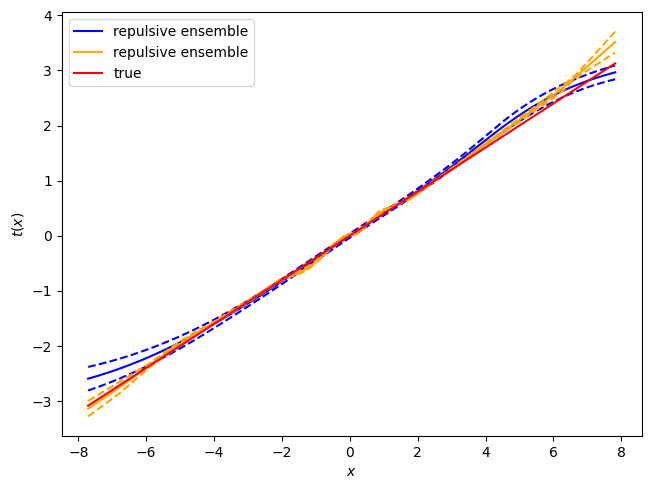

In [35]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.plot(x, t_hat_repulsive_ensemble_sally, c='b', label='repulsive ensemble')
plt.plot(x, t_hat_repulsive_ensemble_sally - t_hat_sig_repulsive_ensemble_sally, c='b', ls='--')
plt.plot(x, t_hat_repulsive_ensemble_sally + t_hat_sig_repulsive_ensemble_sally, c='b', ls='--')

plt.plot(xx.numpy(), repulsive_ensemble_means, c='orange', label='repulsive ensemble')
plt.plot(xx.numpy(), repulsive_ensemble_means - repulsive_ensemble_stds, c='orange', ls='--')
plt.plot(xx.numpy(), repulsive_ensemble_means + repulsive_ensemble_stds, c='orange', ls='--')

plt.plot(x, t_hat_true, c='r', label='true')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()

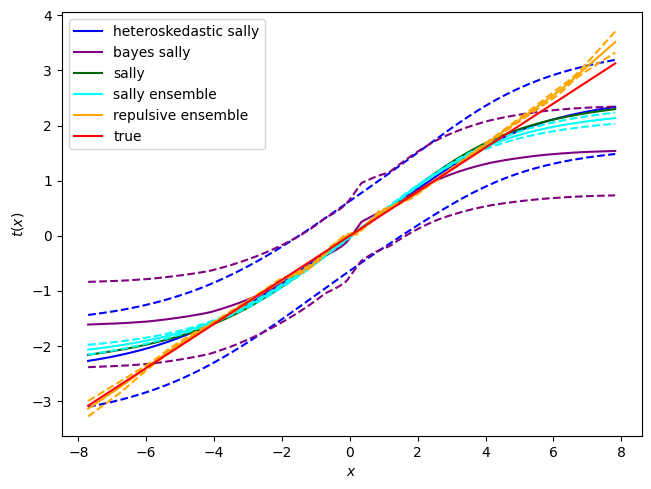

In [36]:
x = np.load("data/x_test.npy")
x = np.sort(x)
t_hat_true = calculate_true_score(x, 0)

fig = plt.figure()

plt.plot(x, t_hat_heteroskedastic_sally,                                   c='b', label='heteroskedastic sally')
plt.plot(x, t_hat_heteroskedastic_sally - t_hat_sig_heteroskedastic_sally, c='b', ls='--')
plt.plot(x, t_hat_heteroskedastic_sally + t_hat_sig_heteroskedastic_sally, c='b', ls='--')
plt.plot(x, t_hat_bayes_sally,                         c='purple', label='bayes sally')
plt.plot(x, t_hat_bayes_sally + t_hat_sig_bayes_sally, c='purple', ls='--')
plt.plot(x, t_hat_bayes_sally - t_hat_sig_bayes_sally, c='purple', ls='--')
plt.plot(x, t_hat_sally.flatten(), c='darkgreen', label='sally')
plt.plot(x, t_hat_sally_ensemble, c='cyan', label='sally ensemble')
plt.plot(x, t_hat_sally_ensemble - t_hat_sig_sally_ensemble, c='cyan', ls='--')
plt.plot(x, t_hat_sally_ensemble + t_hat_sig_sally_ensemble, c='cyan', ls='--')
plt.plot(xx.numpy(), repulsive_ensemble_means, c='orange', label='repulsive ensemble')
plt.plot(xx.numpy(), repulsive_ensemble_means - repulsive_ensemble_stds, c='orange', ls='--')
plt.plot(xx.numpy(), repulsive_ensemble_means + repulsive_ensemble_stds, c='orange', ls='--')
plt.plot(x, t_hat_true, c='r', label='true')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()

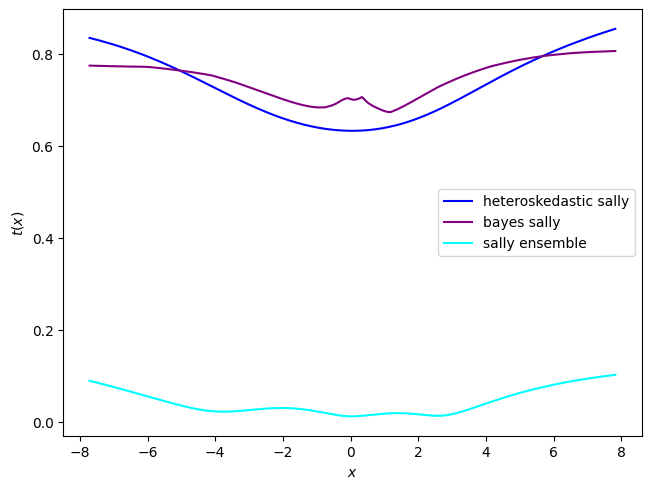

In [37]:
fig = plt.figure()

plt.plot(x, t_hat_sig_heteroskedastic_sally,                                   c='b', label='heteroskedastic sally')
plt.plot(x, t_hat_sig_bayes_sally,                         c='purple', label='bayes sally')
plt.plot(x, t_hat_sig_sally_ensemble,                         c='cyan', label='sally ensemble')

plt.legend()

plt.tight_layout()
plt.xlabel(r"$x$")
plt.ylabel(r"$t(x)$")
plt.show()